## Protein Tokenization Analysis

This notebook will compare tokenization strategies used to classify T cell phenotype strings according to their known (but withheld) subtype.

In [1]:
import pandas as pd
import numpy as np
import warnings
import tqdm
import plotnine as pn
from gensim.models import KeyedVectors
from tcre.env import *
from tcre import integration

In [2]:
path = osp.join(RESULTS_DATA_DIR, 'protein-tokenization', 'dataset.pkl')
df = pd.read_pickle(path)
df = df.reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2780 entries, 0 to 2779
Data columns (total 8 columns):
id                2780 non-null object
start_wrd         2780 non-null int64
end_wrd           2780 non-null int64
text              2780 non-null object
cell_type         2780 non-null object
cell_type_text    2780 non-null object
ptkn              2780 non-null object
clean_text        2780 non-null object
dtypes: int64(2), object(6)
memory usage: 173.8+ KB


In [3]:
df.head()

,id,start_wrd,end_wrd,text,cell_type,cell_type_text,ptkn,clean_text
0,PMC1555646,196,200,human CD4+CD25+Foxp3+ Tregs,Treg,Tregs,"[human, CD4⁺(+), CD25⁺(+), Foxp3⁺(+)]",human CD4+CD25+Foxp3+
1,PMC1867380,5134,5141,CD4+CD25+FoxP3+ IL-10–producing natural T regu...,nTreg,natural T regulatory,"[CD4⁺(+), CD25⁺(+), FoxP3⁺(+), IL-10⁻(–), prod...",CD4+CD25+FoxP3+ IL-10–producing cells
2,PMC1939810,6249,6254,CD4+CD25highCD62L−Foxp3+ regulatory T cells,Treg,regulatory T,"[CD4⁺(+), CD25⁺(high), CD62L⁻(−), Foxp3⁺(+), c...",CD4+CD25highCD62L−Foxp3+ cells
3,PMC1940266,816,821,CD4+CD25+Foxp3+ regulatory T cells,Treg,regulatory T,"[CD4⁺(+), CD25⁺(+), Foxp3⁺(+), cells]",CD4+CD25+Foxp3+ cells
4,PMC1945037,247,254,CD4+ CD25high FoxP3high regulatory T cells,Treg,regulatory T,"[CD4⁺(+), CD25⁺(high), FoxP3⁺(high), cells]",CD4+ CD25high FoxP3high cells


In [4]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message='.*')
    w2v = KeyedVectors.load_word2vec_format(W2V_MODEL_01, binary=True, limit=500000)

In [5]:
w2v.vectors.shape

(500000, 200)

In [6]:
nlp = integration.get_scispacy_pipeline()

CD4+CD45RA+CD45RO-4
-
1BB-CD62L+++CCR7loCD127posCD27positiveCD28hiCD95+TNF-α-CD122
+


In [7]:
def get_features(df, w2v, nlp, use_ptkn=False):
    
    def get_tokens(r):
        if use_ptkn:
            tkns = [((t.token_text or '') + (t.sign_text or '')) for t in r['ptkn']]
        else:
            tkns = list(nlp(r['clean_text']))
        return tkns
            
        
    oov = np.zeros(w2v.vectors.shape[1], dtype=w2v.vectors.dtype)
    def get_vector(w):
        return w2v.get_vector(w) if w in w2v else oov
        
    V = pd.Series([
        np.stack([get_vector(t) for t in get_tokens(r)])
        for i, r in df.iterrows()
    ], index=df.index)
    X = pd.DataFrame([
        V[i].sum(axis=0) for i in range(len(V))], 
        index=df.index)
    y = df['cell_type']
    return V, X, y

In [19]:
#tokenization = 'scispacy'
tokenization = 'ptkn'
V, X, y = get_features(df, w2v, nlp, use_ptkn=tokenization == 'ptkn')

In [20]:
X.shape, y.shape

((2780, 200), (2780,))

In [21]:
y.value_counts().sort_values()

iTreg      10
Tscm       13
TEMRA      28
MAIT       29
Treg1      37
γδT        39
nTreg      40
Th2        46
TEM        71
TCM        73
NKT        75
Th1        78
Th17      144
Tfh       352
Treg     1745
Name: cell_type, dtype: int64

In [22]:
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.linear_model import RidgeClassifierCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score

In [23]:
ests = {
    'xgb': XGBClassifier(random_state=TCRE_SEED),
    'gbr': GradientBoostingClassifier(random_state=TCRE_SEED),
    'ridge': RidgeClassifierCV(normalize=True),
    'mlp': Pipeline([
        ('scale', StandardScaler()), 
        ('est', MLPClassifier(hidden_layer_sizes=(15,), random_state=TCRE_SEED, max_iter=2000))
    ]),
    'svc': Pipeline([
        ('scale', StandardScaler()), 
        ('est', GridSearchCV(SVC(random_state=TCRE_SEED, gamma='auto'), {'C': [.01, .1, .5, 1., 5.]}))
    ]),
    'rnd-strat': DummyClassifier(strategy='stratified', random_state=TCRE_SEED),
    'rnd-mfreq': DummyClassifier(strategy='most_frequent', random_state=TCRE_SEED),
    'rnd-runif': DummyClassifier(strategy='uniform', random_state=TCRE_SEED),
}

In [24]:
dfr = []

def get_scores(y_true, y_pred):
    return {
        'micro-f1': f1_score(y_true, y_pred, average='micro'),
        'macro-f1': f1_score(y_true, y_pred, average='macro'),
        'accuracy': accuracy_score(y_true, y_pred)
    }
    
for k in ests.keys():
    print(f'Fitting {k} ...')
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=TCRE_SEED)
    for i, (train, test) in tqdm.tqdm(list(enumerate(cv.split(X, y)))):
        X_train, y_train = X.iloc[train], y.iloc[train]
        X_test, y_test = X.iloc[test], y.iloc[test]
        est = ests[k]
        est.fit(X_train, y_train)
        y_pred = est.predict(X_test)
        dfr.append({**dict(est=est, est_name=k, fold=i, y_true=y_test, y_pred=y_pred), **get_scores(y_test, y_pred)})
    print('Done')

dfr = pd.DataFrame(dfr)
dfr.head()

  0%|          | 0/10 [00:00<?, ?it/s]

Fitting xgb ...


/opt/conda/envs/nlp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
  0%|          | 0/10 [00:00<?, ?it/s]

Done
Fitting gbr ...


 10%|█         | 1/10 [00:32<04:52, 32.46s/it]/opt/conda/envs/nlp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
 20%|██        | 2/10 [01:05<04:21, 32.67s/it]/opt/conda/envs/nlp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
 30%|███       | 3/10 [01:38<03:48, 32.64s/it]/opt/conda/envs/nlp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
 50%|█████     | 5/10 [02:45<02:45, 33.09s/it]/opt/conda/envs/nlp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: Undefine

Done
Fitting ridge ...


/opt/conda/envs/nlp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/nlp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
 40%|████      | 4/10 [00:00<00:00, 15.14it/s]/opt/conda/envs/nlp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/nlp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn

Done
Fitting mlp ...


/opt/conda/envs/nlp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
 10%|█         | 1/10 [00:03<00:35,  3.92s/it]/opt/conda/envs/nlp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
 20%|██        | 2/10 [00:07<00:29,  3.73s/it]/opt/conda/envs/nlp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
 30%|███       | 3/10 [00:11<00:27,  3.88s/it]/opt/conda/envs/nlp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and bei

Done
Fitting svc ...


/opt/conda/envs/nlp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
 10%|█         | 1/10 [00:15<02:17, 15.28s/it]/opt/conda/envs/nlp/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/opt/conda/envs/nlp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
 20%|██        | 2/10 [00:30<02:02, 15.30s/it]/opt/conda/envs/nlp/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Sp

Done
Fitting rnd-strat ...
Done
Fitting rnd-mfreq ...


100%|██████████| 10/10 [00:00<00:00, 98.53it/s]

Done
Fitting rnd-runif ...
Done


,accuracy,est,est_name,fold,macro-f1,micro-f1,y_pred,y_true
0,0.855634,"XGBClassifier(base_score=0.5, booster='gbtree'...",xgb,0,0.584804,0.855634,"[Treg, Treg, Treg, Th17, Treg, Treg, Treg, Tre...",5 Treg 6 Treg 21 Treg 28 ...
1,0.833922,"XGBClassifier(base_score=0.5, booster='gbtree'...",xgb,1,0.608914,0.833922,"[Th2, Treg, Treg, Treg, Treg, Treg, Treg, Treg...",10 Th2 24 Treg 30 Treg 41 ...
2,0.854610,"XGBClassifier(base_score=0.5, booster='gbtree'...",xgb,2,0.490487,0.854610,"[nTreg, Treg, Treg, Treg, TEM, Tfh, Treg, Treg...",17 Treg 31 Treg 32 NKT 35 ...
3,0.803571,"XGBClassifier(base_score=0.5, booster='gbtree'...",xgb,3,0.436746,0.803571,"[Treg, Treg, Th2, Treg, Treg, Treg, MAIT, γδT,...",0 Treg 2 Treg 33 Th17 38 ...
4,0.845878,"XGBClassifier(base_score=0.5, booster='gbtree'...",xgb,4,0.622824,0.845878,"[Treg, Treg, Tfh, Th17, Treg, Treg, Treg, Treg...",13 nTreg 44 Treg 47 Th1 53 ...


## Export

In [25]:
path = osp.join(RESULTS_DATA_DIR, 'protein-tokenization', 'modeling-results-{}.pkl'.format(tokenization))
dfr.to_pickle(path)
path

'/lab/data/results/protein-tokenization/modeling-results-ptkn.pkl'

## Load Results

In [27]:
dfr = pd.concat([
    pd.read_pickle(osp.join(RESULTS_DATA_DIR, 'protein-tokenization', 'modeling-results-{}.pkl'.format(t)))
    .assign(tokenization=t)
    for t in ['ptkn', 'scispacy']
]).reset_index(drop=True)
dfr.head()

,accuracy,est,est_name,fold,macro-f1,micro-f1,y_pred,y_true,tokenization
0,0.855634,"XGBClassifier(base_score=0.5, booster='gbtree'...",xgb,0,0.584804,0.855634,"[Treg, Treg, Treg, Th17, Treg, Treg, Treg, Tre...",5 Treg 6 Treg 21 Treg 28 ...,ptkn
1,0.833922,"XGBClassifier(base_score=0.5, booster='gbtree'...",xgb,1,0.608914,0.833922,"[Th2, Treg, Treg, Treg, Treg, Treg, Treg, Treg...",10 Th2 24 Treg 30 Treg 41 ...,ptkn
2,0.854610,"XGBClassifier(base_score=0.5, booster='gbtree'...",xgb,2,0.490487,0.854610,"[nTreg, Treg, Treg, Treg, TEM, Tfh, Treg, Treg...",17 Treg 31 Treg 32 NKT 35 ...,ptkn
3,0.803571,"XGBClassifier(base_score=0.5, booster='gbtree'...",xgb,3,0.436746,0.803571,"[Treg, Treg, Th2, Treg, Treg, Treg, MAIT, γδT,...",0 Treg 2 Treg 33 Th17 38 ...,ptkn
4,0.845878,"XGBClassifier(base_score=0.5, booster='gbtree'...",xgb,4,0.622824,0.845878,"[Treg, Treg, Tfh, Th17, Treg, Treg, Treg, Treg...",13 nTreg 44 Treg 47 Th1 53 ...,ptkn


In [28]:
dfs = (
    dfr
    .drop(['est', 'y_pred', 'y_true'], axis=1)
    .set_index(['tokenization', 'est_name', 'fold'])
    .rename_axis('metric', axis='columns').stack().rename('value')
    .reset_index()
)
dfs.head()

,tokenization,est_name,fold,metric,value
0,ptkn,xgb,0,accuracy,0.855634
1,ptkn,xgb,0,macro-f1,0.584804
2,ptkn,xgb,0,micro-f1,0.855634
3,ptkn,xgb,1,accuracy,0.833922
4,ptkn,xgb,1,macro-f1,0.608914


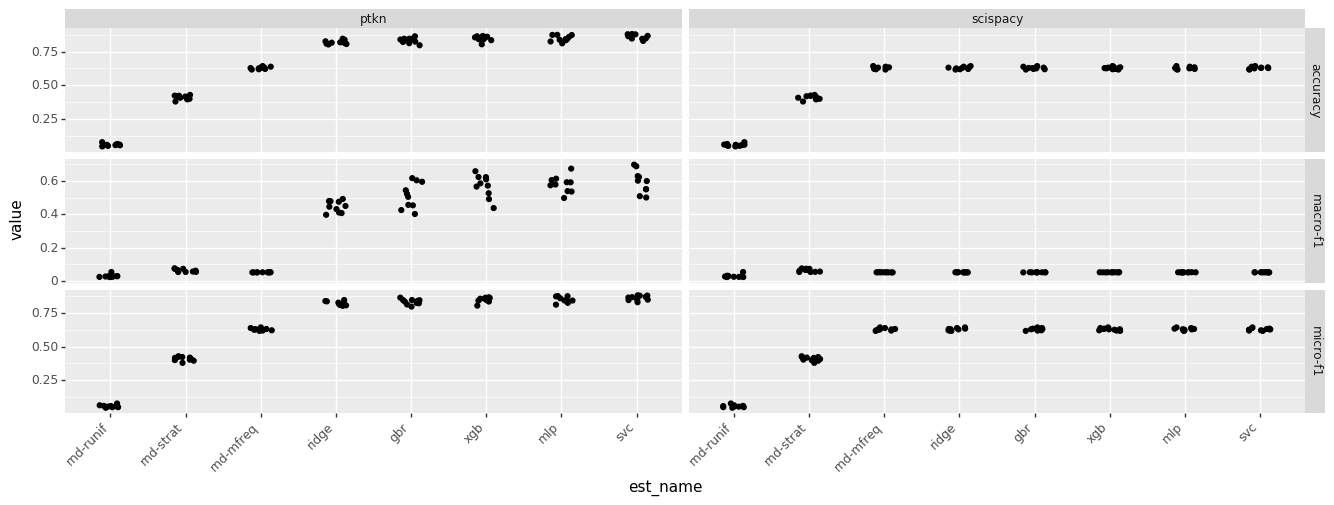

<ggplot: (8754938278369)>

In [31]:
(
    pn.ggplot(
        dfs
            .assign(est_name=lambda df: pd.Categorical(
                df['est_name'], ordered=True, 
                categories=df.groupby(['est_name', 'metric'])['value'].mean().unstack()['micro-f1'].sort_values().index
            ))
        , 
        pn.aes(x='est_name', y='value')
    ) + 
    pn.geom_jitter(random_state=1, width=.15) + 
    pn.facet_grid('metric ~ tokenization', scales='free') + 
    pn.theme(figure_size=(16, 5), axis_text_x=pn.element_text(rotation=45, hjust=1))
)

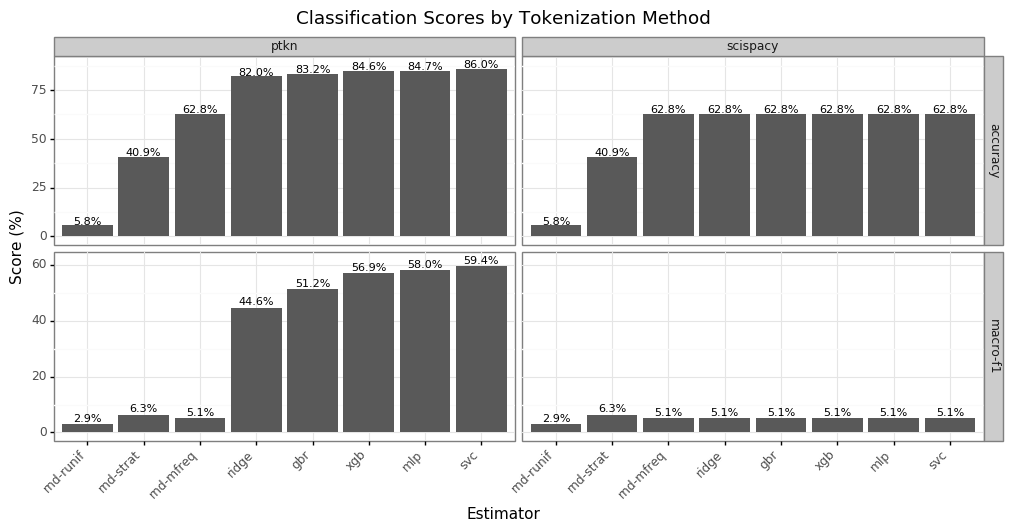

<ggplot: (-9223363281919279174)>

In [47]:
def plot_metrics(metrics):
    return (
        pn.ggplot(
            dfs
                .pipe(lambda df: df[df['metric'].isin(metrics)])
                #.pipe(lambda df: df[df['tokenization'].isin([tokenizations])])
                .groupby(['tokenization', 'est_name', 'metric'])['value'].mean().rename('value').reset_index()
                .assign(value=lambda df: 100*df['value'])
                .assign(text=lambda df: df['value'].map('{:.1f}%'.format))
                .assign(est_name=lambda df: pd.Categorical(
                    df['est_name'], ordered=True, 
                    categories=df.groupby(['est_name', 'metric'])['value'].mean().unstack()[metrics[0]].sort_values().index
                ))
            , 
            pn.aes(x='est_name', y='value', label='text')
        ) + 
        pn.geom_bar(stat='identity', position=pn.position_dodge(width=1)) +
        pn.geom_text(nudge_y=2, size=8) + 
        pn.facet_grid('metric ~ tokenization', scales='free') + 
        pn.labs(x='Estimator', y='Score (%)', title='Classification Scores by Tokenization Method') + 
        pn.theme_bw() + 
        pn.theme(figure_size=(12, 5), axis_text_x=pn.element_text(rotation=45, hjust=1))
    )
plot_metrics(['accuracy', 'macro-f1'])

In [44]:
from sklearn.metrics import classification_report, confusion_matrix
best_est = 'svc'
best_tkn = 'ptkn'
dft = dfr.pipe(lambda df: df[df['est_name'] == best_est]).pipe(lambda df: df[df['tokenization'] == best_tkn])
est = dft['est'].iloc[0]
y_pred = np.concatenate([v for v in dft['y_pred']])
y_true = np.concatenate([v for v in dft['y_true']])
assert y_pred.shape == y_true.shape

In [45]:
print(classification_report(y_true, y_pred, labels=est.classes_))

              precision    recall  f1-score   support

        MAIT       0.69      0.62      0.65        29
         NKT       0.84      0.63      0.72        75
         TCM       0.71      0.66      0.68        73
         TEM       0.50      0.48      0.49        71
       TEMRA       0.74      0.50      0.60        28
         Tfh       0.79      0.89      0.84       352
         Th1       0.65      0.42      0.51        78
        Th17       0.82      0.71      0.76       144
         Th2       0.88      0.61      0.72        46
        Treg       0.91      0.97      0.94      1745
       Treg1       0.77      0.73      0.75        37
        Tscm       0.75      0.46      0.57        13
       iTreg       0.75      0.30      0.43        10
       nTreg       0.40      0.10      0.16        40
         γδT       0.74      0.44      0.55        39

    accuracy                           0.86      2780
   macro avg       0.73      0.57      0.62      2780
weighted avg       0.85   

In [46]:
pd.DataFrame(confusion_matrix(y_true, y_pred), index=est.classes_, columns=est.classes_).style.background_gradient()

,MAIT,NKT,TCM,TEM,TEMRA,Tfh,Th1,Th17,Th2,Treg,Treg1,Tscm,iTreg,nTreg,γδT
MAIT,18,1,0,4,0,2,0,1,0,2,0,0,0,0,1
NKT,1,47,2,0,0,10,1,4,1,8,0,0,0,0,1
TCM,0,0,48,10,0,1,1,0,0,12,0,1,0,0,0
TEM,2,2,8,34,3,5,1,0,0,11,0,0,0,2,3
TEMRA,0,0,0,4,14,1,0,0,0,7,0,1,0,1,0
Tfh,0,0,1,5,0,314,8,0,1,23,0,0,0,0,0
Th1,0,1,0,0,0,25,33,3,1,15,0,0,0,0,0
Th17,0,2,0,0,0,16,3,102,1,19,0,0,0,0,1
Th2,0,1,0,2,0,3,2,2,28,8,0,0,0,0,0
Treg,1,1,7,6,1,16,1,4,0,1696,8,0,1,3,0
